In [1]:
import os
import pandas as pd

In [2]:
os.chdir('C:/Users/HK/Desktop/LAB/RNN/S2S')

### 데이터 준비

In [3]:
lines = pd.read_table('fra.txt', names = ['source', 'target'])

In [4]:
print(len(lines), 'observations')
lines = lines.head(10000) # 메모리 문제로 10000개만 사용
lines.sample(10)

170190 observations


,source,target
9693,Are you certain?,En êtes-vous sûre ?
3581,I have to go.,Je dois m'en aller.
5972,It's all true.,Tout est vrai.
6409,They're drunk.,Elles sont saoules.
5924,It looks nice.,Ça a l'air bien.
3670,I started it.,Je l'ai démarré.
9839,Can we fix this?,Pouvons-nous arranger ça ?
410,Save Tom.,Sauvez Tom.
1006,Who cares?,À qui ceci importe-t-il ?
6466,Tie your shoe.,Attachez votre lacet.


In [5]:
# 문장의 시작을 의미하는 '\t'
# 문장의 종료를 의미하는 '\n'를 각 문장 앞뒤에 추가히기

lines.target = lines.target.apply(lambda x : '\t' + x + '\n')
lines.sample(10)

,source,target
63,No way!,\tEn aucune manière !\n
3592,I keep a dog.,\tJ'élève un chien.\n
12,Stop!,\tArrête-toi !\n
207,Wake up.,\tRéveille-toi !\n
2775,That's ugly.,\tC'est laid.\n
651,I saw one.,\tJ'en ai vu un.\n
8741,She hugged him.,\tElle l'enlaça.\n
4413,Trust no one.,\tNe fais confiance à personne !\n
5587,I was careful.,\tJ'étais prudente.\n
8526,Keep the money.,\tGardez l'argent.\n


In [6]:
# 글자집합 구축
# source, target 시퀀스 각각 사전(글자집합)에 글자 추가

source_vocab = set()
for line in lines.source: # 문장 한 줄씩 읽음
    for char in line:     # 글자 한 개씩 읽음
        source_vocab.add(char)
        
target_vocab = set()
for line in lines.target: 
    for char in line:     
        target_vocab.add(char)        

In [7]:
source_vocab_size = len(source_vocab) +1
target_vocab_size = len(target_vocab) +1

print('source 글자 개수:', source_vocab_size)
print('target 글자 개수:', target_vocab_size)

source 글자 개수: 71
target 글자 개수: 94


In [8]:
# 집합을 리스트로 변환하고 정렬

source_vocab = sorted(list(source_vocab))
target_vocab = sorted(list(target_vocab))

print(source_vocab[10:20])
print(target_vocab[10:20])

['1', '2', '3', '5', '6', '7', '8', '9', ':', '?']
[',', '-', '.', '0', '1', '2', '3', '5', '8', '9']


In [9]:
# 각 사전의 글자에 인덱스 부여

source_to_index = dict([(word, i+1) for i, word in enumerate(source_vocab)])
target_to_index = dict([(word, i+1) for i, word in enumerate(target_vocab)])

# print(source_to_index)
# print(target_to_index)

In [10]:
# 시퀀스 데이터에 정수 인코딩 (영어 source)

encoder_input = []
for line in lines.source:
    tempX = []
    for w in line:                        # 글자 하나씩
        tempX.append(source_to_index[w])  # 글자에 해당하는 정수 인덱스 추가
    encoder_input.append(tempX)

In [11]:
print(encoder_input[:5])

[[27, 59, 9], [28, 53, 9], [28, 53, 9], [38, 65, 58, 2], [38, 65, 58, 2]]


In [12]:
# 정수 인코딩 (한국어 target)

decoder_input = []
for line in lines.target:
    tempX = []
    for w in line:
        tempX.append(target_to_index[w])
    decoder_input.append(tempX)

In [13]:
# 디코더의 예측 값과 비교하기 위한 실제 값 인코딩
# 여기서는 시작 심볼 '\t'가 있을 필요가 없음 (사전에서 0:'\t')

decoder_target = []
for line in lines.target:
    t = 0
    tempX = []
    for w in line:
        if t > 0:
            tempX.append(target_to_index[w])
        t = t + 1
    decoder_target.append(tempX)

In [14]:
max_source_len = max([len(line) for line in lines.source])
max_target_len = max([len(line) for line in lines.target])

print('source 최대 문장길이:', max_source_len)
print('target 최대 문장길이:', max_target_len)

source 최대 문장길이: 16
target 최대 문장길이: 59


In [15]:
# 시퀀스-투-시퀀스 모델에서 데이터 하나의 쌍끼리는 길이가 같을 필요는 없음
# source 시퀀스, target 시퀀스끼리 각각 길이를 맞춰서 패딩하면 됨

# source/target 별로 가장 최대길이에 맞춰서 패딩 (앞에 채우기)

from keras.preprocessing.sequence import pad_sequences

encoder_input = pad_sequences(encoder_input, max_source_len, padding = 'post')
decoder_input = pad_sequences(decoder_input, max_target_len, padding = 'post')
decoder_target = pad_sequences(decoder_target, max_target_len, padding = 'post')

Using TensorFlow backend.


In [16]:
# 원-핫 인코딩
# 글자 단위 번역기이므로 워드 임베딩 사용 안함

from keras.utils.np_utils import to_categorical

encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### SEQ2SEQ 기계번역기 훈련시키기 (교사학습)

In [17]:
from keras.layers import Input, GRU, LSTM, Embedding, Dense
from keras.models import Model, load_model, save_model
from keras import optimizers
import keras.backend as K

In [18]:
K.clear_session()

In [19]:
rnn_units = 128

In [20]:
# 인코더 설계

encoder_inputs = Input(shape = (None, source_vocab_size))
encoder_lstm = LSTM(units = rnn_units, return_state = True)
# 인코더의 내부 상태를 디코더로 넘겨줘야 하므로 state도 같이 리턴함

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs는 리턴받지만 여기서는 필요없음

encoder_states = [state_h, state_c]
# 넘겨줄 인코더 statee들 (LSTM이라 2개) : 이것이 곧 컨텍스트(context) 백터

In [21]:
# 디코더 설계

decoder_inputs = Input(shape = (None, target_vocab_size))
decoder_lstm = LSTM(units = rnn_units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 함
# 디코더에서는 리턴되는 값 중 output만 필요함

decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [22]:
# 모형 설계

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# 인코더 입력과 디코더 입력을 받아서 디코더 출력

model.compile(optimizer = optimizers.adam(),
              loss = "categorical_crossentropy",
              metrics = ['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 94)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 102400      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  114176      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [25]:
epochs = 100
batch_size = 128

history = model.fit([encoder_input, decoder_input], decoder_target,
                    validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose = 2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 25s - loss: 2.0440 - acc: 0.6658 - val_loss: 1.4861 - val_acc: 0.6636
Epoch 2/100
 - 22s - loss: 1.1509 - acc: 0.7097 - val_loss: 1.1682 - val_acc: 0.6790
Epoch 3/100
 - 23s - loss: 0.9835 - acc: 0.7319 - val_loss: 1.0614 - val_acc: 0.7046
Epoch 4/100
 - 23s - loss: 0.9088 - acc: 0.7508 - val_loss: 1.0056 - val_acc: 0.7130
Epoch 5/100
 - 23s - loss: 0.8556 - acc: 0.7658 - val_loss: 0.9463 - val_acc: 0.7469
Epoch 6/100
 - 22s - loss: 0.7985 - acc: 0.7850 - val_loss: 0.8863 - val_acc: 0.7639
Epoch 7/100
 - 23s - loss: 0.7430 - acc: 0.7979 - val_loss: 0.8300 - val_acc: 0.7707
Epoch 8/100
 - 23s - loss: 0.6949 - acc: 0.8068 - val_loss: 0.7821 - val_acc: 0.7807
Epoch 9/100
 - 22s - loss: 0.6557 - acc: 0.8153 - val_loss: 0.7413 - val_acc: 0.7897
Epoch 10/100
 - 23s - loss: 0.6246 - acc: 0.8224 - val_loss: 0.7135 - val_acc: 0.7964
Epoch 11/100
 - 22s - loss: 0.5976 - acc: 0.8291 - val_loss: 0.6867 - val_acc: 0.8010
Epoch 12/100
 -

Epoch 96/100
 - 21s - loss: 0.2241 - acc: 0.9329 - val_loss: 0.5166 - val_acc: 0.8635
Epoch 97/100
 - 22s - loss: 0.2226 - acc: 0.9334 - val_loss: 0.5239 - val_acc: 0.8624
Epoch 98/100
 - 23s - loss: 0.2207 - acc: 0.9338 - val_loss: 0.5203 - val_acc: 0.8633
Epoch 99/100
 - 23s - loss: 0.2193 - acc: 0.9343 - val_loss: 0.5188 - val_acc: 0.8637
Epoch 100/100
 - 22s - loss: 0.2173 - acc: 0.9351 - val_loss: 0.5218 - val_acc: 0.8630


In [28]:
import matplotlib.pyplot as plt

def history_plot(history, model = 1):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(len(acc))]
    
    plt.plot(epochs, loss, '-k', label = 'Training')
    plt.plot(epochs, val_loss, ':r', label = 'Validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, acc, '-k', label = 'Training')
    plt.plot(epochs, val_acc, ':r', label = 'Validation')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

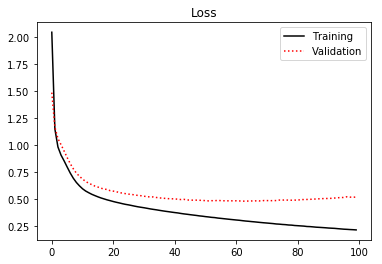

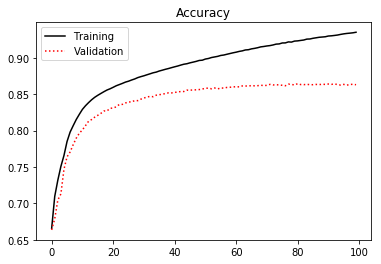

In [29]:
history_plot(history)

### 기계번역 동작 (예측)

In [31]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (rnn_units,))
decoder_state_input_c = Input(shape = (rnn_units,))
decoder_states_inputs_p = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs_p, state_h_p, state_c_p = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs_p)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs_p, [decoder_outputs_p] + decoder_states_p)

In [32]:
index_to_source = dict((i, char) for char, i in source_to_index.items())
index_to_target = dict((i, char) for char, i in target_to_index.items())

In [33]:
def decode_sentence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # 문장 시작에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, target_vocab_size))
    target_seq[0, 0, target_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_target_len):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태를 업데이트
        states_value = [h, c]

    return decoded_sentence

In [34]:
import numpy as np

for i in np.random.randint(0, len(lines) - 1, size = 3):
    input_sequence = encoder_input[i:i+1]
    decoded_sentence = decode_sentence(input_sequence)
    
    print(50 * '-')
    print('입력 문장:', lines.source[i])
    print('정답 문장:', lines.target[i][1:len(lines.target[i])-1])
    print('번역기:', decoded_sentence)

--------------------------------------------------
입력 문장: I like beer.
정답 문장: J'aime la bière.
번역기: J'aime le la maintenant.

--------------------------------------------------
입력 문장: You're through.
정답 문장: Vous en avez fini.
번역기: Vous êtes bincelle.

--------------------------------------------------
입력 문장: I'm powerless.
정답 문장: Je suis désarmé.
번역기: Je suis prépasée.

